## Introduction:

The objective of this project is to develop a fraud detection system for a bank web application. The system aims to detect fraudulent transactions by analyzing various features associated with each transaction. By implementing machine learning techniques, specifically logistic regression, we aim to classify transactions as fraudulent or legitimate based on their characteristics.

## Data Overview:

The dataset used for this project was obtained from Kaggle and consists of transaction data with the following features:

* Distance from Home
* Distance from Last Transaction
* Ratio to Median Purchase Price
* Repeat Retailer
* Used Chip
* Used Pin Number
* Online Order
* Fraud (Target Variable)

## Data Preprocessing:

* The dataset is loaded using pandas and examined to understand its structure and features.

* Features are split into independent variables (X) and the target variable (y).

* Data is split into training and testing sets using a ratio of 80:20, with stratification to maintain class balance.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

In [2]:
path = '/content/data.csv'
data = pd.read_csv(path)

X = data.drop('fraud', axis=1)  # Features
y = data['fraud']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
print(data.columns)

Index(['distance_from_home', 'distance_from_last_transaction',
       'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip',
       'used_pin_number', 'online_order', 'fraud'],
      dtype='object')


## Model Training:

---

* A logistic regression model is trained on the training data.

* Hyperparameter tuning is performed using grid search with cross-validation to find the optimal value of the regularization parameter (C).

* The best model is selected based on the hyperparameters yielding the highest accuracy on the validation set.



## Hyberparam

In [3]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
model1 = LogisticRegression(max_iter=1000)

In [4]:
grid_search = GridSearchCV(estimator=model1, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='accuracy')

In [5]:
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'C': 100}


In [6]:
best_model = LogisticRegression(max_iter=1000, C=best_params['C'])

# Train the model on the training data
best_model.fit(X_train, y_train)

LogisticRegression(C=100, max_iter=1000)

In [7]:
import joblib

# Assuming `best_model` is your trained model
joblib.dump(best_model, 'fraud_detection_model.joblib')

['fraud_detection_model.joblib']

In [ ]:
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.958725
Confusion Matrix:
 [[181277   1280]
 [  6975  10468]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.99      0.98    182557
         1.0       0.89      0.60      0.72     17443

    accuracy                           0.96    200000
   macro avg       0.93      0.80      0.85    200000
weighted avg       0.96      0.96      0.96    200000



These metrics provide insights into the model's performance:
- **Accuracy:** The proportion of correctly predicted instances is approximately 95.87%.
- **Confusion Matrix:** Shows the counts of true positive, false positive, true negative, and false negative predictions. In this case, there are 181,277 true negatives, 1,280 false positives, 6,975 false negatives, and 10,468 true positives.
- **Classification Report:** Provides precision, recall, F1-score, and support for each class (fraudulent and legitimate transactions). The model achieved high precision (0.96) and recall (0.99) for legitimate transactions (class 0), indicating a low false positive rate.

Overall, the model demonstrates strong performance in identifying legitimate transactions, but there is some room for improvement in detecting fraudulent transactions, particularly in increasing recall to capture more instances of fraud while minimizing false negatives.

## Model Interpretation:
---
* Feature importance is analyzed using two methods: ELI5 and SHAP.
* ELI5 library is used to visualize feature weights, indicating their impact on the model's predictions.
* SHAP (SHapley Additive exPlanations) values are calculated to explain the impact of each feature on individual predictions.
* Feature importance is ranked based on the mean absolute SHAP values, showing the most influential features in detecting fraud.

In [ ]:
!pip install eli5

In [ ]:
import eli5
eli5.show_weights(best_model, feature_names=list(X.columns))

Weight?,Feature
+6.662,online_order
+0.861,ratio_to_median_purchase_price
+0.025,distance_from_last_transaction
+0.015,distance_from_home
-0.615,repeat_retailer
-1.042,used_chip
-10.374,<BIAS>
-13.605,used_pin_number


In [ ]:
eli5_df = eli5.explain_weights_df(best_model, feature_names=list(X.columns))
eli5_df

,target,feature,weight
0,1.0,online_order,6.661864
1,1.0,ratio_to_median_purchase_price,0.861299
2,1.0,distance_from_last_transaction,0.025494
3,1.0,distance_from_home,0.015148
4,1.0,repeat_retailer,-0.615098
5,1.0,used_chip,-1.041773
6,1.0,<BIAS>,-10.374283
7,1.0,used_pin_number,-13.605163


In [ ]:
!pip install shap

In [ ]:
import shap
import matplotlib.pyplot as plt

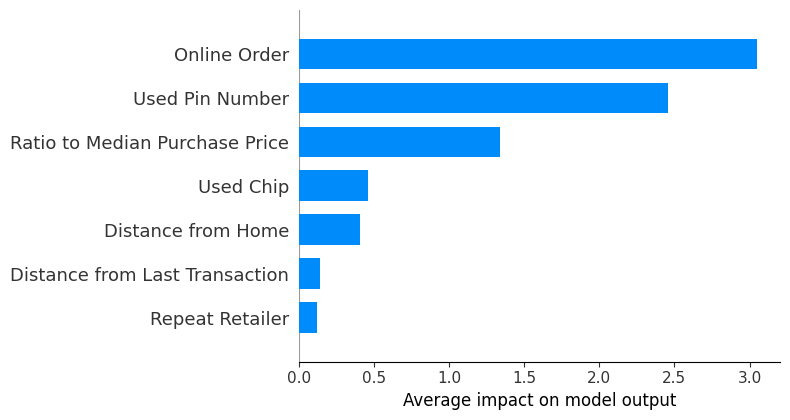

In [ ]:
feature_names = ['Distance from Home', 'Distance from Last Transaction', 'Ratio to Median Purchase Price',
                 'Repeat Retailer', 'Used Chip', 'Used Pin Number', 'Online Order']

# Initialize a SHAP explainer
explainer = shap.Explainer(best_model, X_train)

# Calculate SHAP values for all features in the training data
shap_values = explainer.shap_values(X_train)

# Visualize feature importance
shap.summary_plot(shap_values, X_train, plot_type='bar', feature_names=feature_names, show=False)
fig, ax = plt.gcf(), plt.gca()

# Customize the x-axis label
ax.set_xlabel('Average impact on model output', fontsize=12)


# Display the plot
plt.show()

## Feature Importance from ELI5:
According to ELI5, the most influential features for predicting fraud are "Online Order," "Ratio to Median Purchase Price," and "Distance from Last Transaction." These features have positive weights, indicating that an increase in their values leads to a higher likelihood of fraud.

The feature "used_pin_number" has a weight of -13.605023 according to the ELI5 explanation. This negative weight indicates that an increase in the value of this feature decreases the log-odds of the target variable being 1 (fraudulent). In other words, transactions where the "used_pin_number" feature is present are less likely to be classified as fraudulent by the model.


## Feature Importance from SHAP:
SHAP values indicate that "Online Order" and "Used Pin Number" are the most important features for predicting fraud, followed by "Ratio to Median Purchase Price." These features have the highest mean absolute SHAP values, indicating their strong influence on model predictions.

##Consistent Findings:
Both ELI5 and SHAP identify "Online Order" as one of the most important features for predicting fraud, with a positive impact. This consistency strengthens the interpretation of this feature's significance in detecting fraudulent transactions.

## Testing

---
* Legitimate case

In [ ]:
def predict_fraud(transaction_data, model):
    # Preprocess transaction data
    transaction_df = pd.DataFrame(transaction_data, index=[0])  # Convert input to DataFrame

    # Use the trained model to predict
    probability_fraud = model.predict_proba(transaction_df)[:, 1]

    # Apply threshold (e.g., 0.5) to classify as fraud or not
    threshold = 0.5
    if probability_fraud >= threshold:
        prediction = "Fraudulent"
    else:
        prediction = "Legitimate"

    return prediction, probability_fraud[0]

# Example usage:
transaction = {
    'distance_from_home': 10,
    'distance_from_last_transaction': 5,
    'ratio_to_median_purchase_price': 0.8,
    'repeat_retailer': 0,
    'used_chip': 1,
    'used_pin_number': 1,
    'online_order': 0
}

fraud_prediction, probability_score = predict_fraud(transaction, best_model)
print("Prediction:", fraud_prediction)
print("Probability of Fraud:", probability_score)

Prediction: Legitimate
Probability of Fraud: 3.579424776732348e-11


* Fraudulent case

In [ ]:
fraudulent_transaction = {
    'distance_from_home': 55,
    'distance_from_last_transaction': 19,
    'ratio_to_median_purchase_price': 3.0,
    'repeat_retailer': 0,
    'used_chip': 0,
    'used_pin_number': 0,
    'online_order': 1
}

fraud_prediction, probability_score = predict_fraud(fraudulent_transaction, best_model)
print("Prediction:", fraud_prediction)
print("Probability of Fraud:", probability_score)

Prediction: Fraudulent
Probability of Fraud: 0.547106013655952


## Summary
---

Our analysis identified key features that significantly contribute to the prediction of fraudulent transactions in our banking system. Leveraging these findings can provide several benefits to our organization, including:

Improved Fraud Detection Systems: By incorporating the identified features into our fraud detection algorithms, we can enhance our ability to identify and prevent fraudulent transactions, thereby minimizing financial losses and protecting our assets.
Targeted Risk Mitigation Strategies: Understanding the factors associated with fraud enables us to develop more targeted risk mitigation strategies. By focusing on the most influential features, we can allocate resources effectively and implement measures to mitigate the risk of fraudulent activities.
Enhanced Customer Experience: A robust fraud detection system not only protects our organization but also enhances the experience for our customers. By promptly detecting and resolving fraudulent transactions, we can build trust and confidence among our customers, leading to increased satisfaction and loyalty.
Cost Savings: Effective fraud detection can result in significant cost savings by reducing financial losses associated with fraudulent activities. By identifying and preventing fraudulent transactions early, we can avoid chargebacks, refunds, and other expenses related to fraud.

## Conclusion:
---
In conclusion, this project demonstrates the development of a fraud detection system for a bank web application using logistic regression. By leveraging machine learning techniques and interpreting model predictions, the system can effectively identify fraudulent transactions and mitigate financial risks. Further enhancements and refinements can be made to optimize the system's performance and ensure robustness in real-world scenarios.